## 1. Data Exploration

### Data Inspection Goals: 

* 1. Class Imbalance Detection: Identify if certain labels have significantly fewer samples than others. 
    * Action: Use **Stratified Splitting** to ensure more balanced class representation and **Data Augmentation** of the images  to increase the number of samples for each label and prevent overfitting.
* 2. Label Consistency Check: Determine whether the labels are consistent throughout **Train**, **Validation**, and **Test** splits. 
    * Action: Ensure that all classes seen in the **Test** split are present in the **Validation** and **Train** splits using Straitifed Splitting, as mentioned above.

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_setup import download_dataset, load_local_data

# Download and load dataset
raw_path = "../data"
data_exists_path = os.path.join(raw_path, "fcakyon___pokemon-classification")

# Download data if it doesnt exist yet
if not data_exists_path:
    print(f"Data not found at path {data_exists_path}. Starting download...")
    download_dataset(raw_path=raw_path)
else:
    print(f"Data exists locally. Loading from path {data_exists_path}")
    
dataset = load_local_data(data_exists_path)


Data exists locally. Loading from path ../data/fcakyon___pokemon-classification
Found local data files: ['train', 'test', 'validation']


In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4939
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 802
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1460
    })
})


### Determine Number of Unique Labels in each Data Split

In [3]:
import numpy as np

def get_unique_labels(dataset):
    """Given a dataset, determines the the unique labels within each split of the data

    Args:
        dataset (DataSet): 
    Returns:
        A dictionary where the keys are the data split and the values are the unique labels that exist within that split.
    """
    unique_labels = {}
    
    for split in dataset:
        unique_labels[split] = np.unique(dataset[split]["labels"])
        print(f"Number of unique labels for {split} split: {len(unique_labels[split])}")
    return unique_labels

### Data label inconsistency between splits
The fcakyon___pokemon-classification dataset contains a different number of labels between the train, validation, and test sets. As the data splits currently stand, the model would be trained on 137 labels, but only validated and tested on 35 and 48 labels respectively. This means that currently we would be unable to accurately access the performance of our model on approximately 65% of the data. 

In [4]:

unique_labels_ds = get_unique_labels(dataset)


Number of unique labels for train split: 137
Number of unique labels for test split: 48
Number of unique labels for validation split: 35


### Count Number of Samples per Label

In [101]:

from collections import Counter
def get_counts_per_split(dataset, swap):
    """For each split in the dataset, counts the number of samples for each label.

    Args:
        dataset (DataSet): _description_
    Returns:
        a dictionary of Counter objects containing the counts of each label in each data split
    """
    counts = {}
    for split in dataset:
        counts[split] = Counter(dataset[split]["labels"])
    # Order dict keys in to be -> train, validation, test
    if swap:
        counts = [(k,v) for (k, v) in counts.items()]
        counts[1], counts[2] = counts[2], counts[1]
        counts = dict(counts)
    return counts
        


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_individual_splits(dataset, title=None, swap=False):
    """For the train, validation, and test splits: plot the number of samples per label

    Args:
        dataset (DataSet): DataSet containing a train, test, and validation split
    """
        # get counts of each data split
    counts = get_counts_per_split(dataset, swap)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    if title is not None:
        fig.suptitle(title, fontsize=16)
   
    colors = ["#4C72B0", "#55A868", "#C44E52"]
    
    # Iterate through each split and its assigned axis
    for i, (split, class_counts) in enumerate(counts.items()):
        # Convert the Counter to a DataFrame for Seaborn
        df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"]).sort_values("Class")
        
        sns.barplot(data=df, x="Class", y="Count", ax=axes[i], color=colors[i])
        
        # subplots formatting
        axes[i].set_title(f"Split: {split.capitalize()}")
        axes[i].set_xlabel("Class Label")
        axes[i].tick_params(axis='x', rotation=90) 
        
        # Hide y-label for 2nd and 3rd plots
        if i == 0:
            axes[i].set_ylabel("Number of Instances")
        else:
            axes[i].set_ylabel("") 
  
    plt.tight_layout()
    plt.show()


### Visualizing the Class Imbalance
From the plots below it is clear that the number of samples for each label varies greatly, especially within our training and test splits. In addition to this class imbalance, it is abundantly clear that the number of training labels far exceeds the number of validation and test labels. We will need to stratify our data splits.

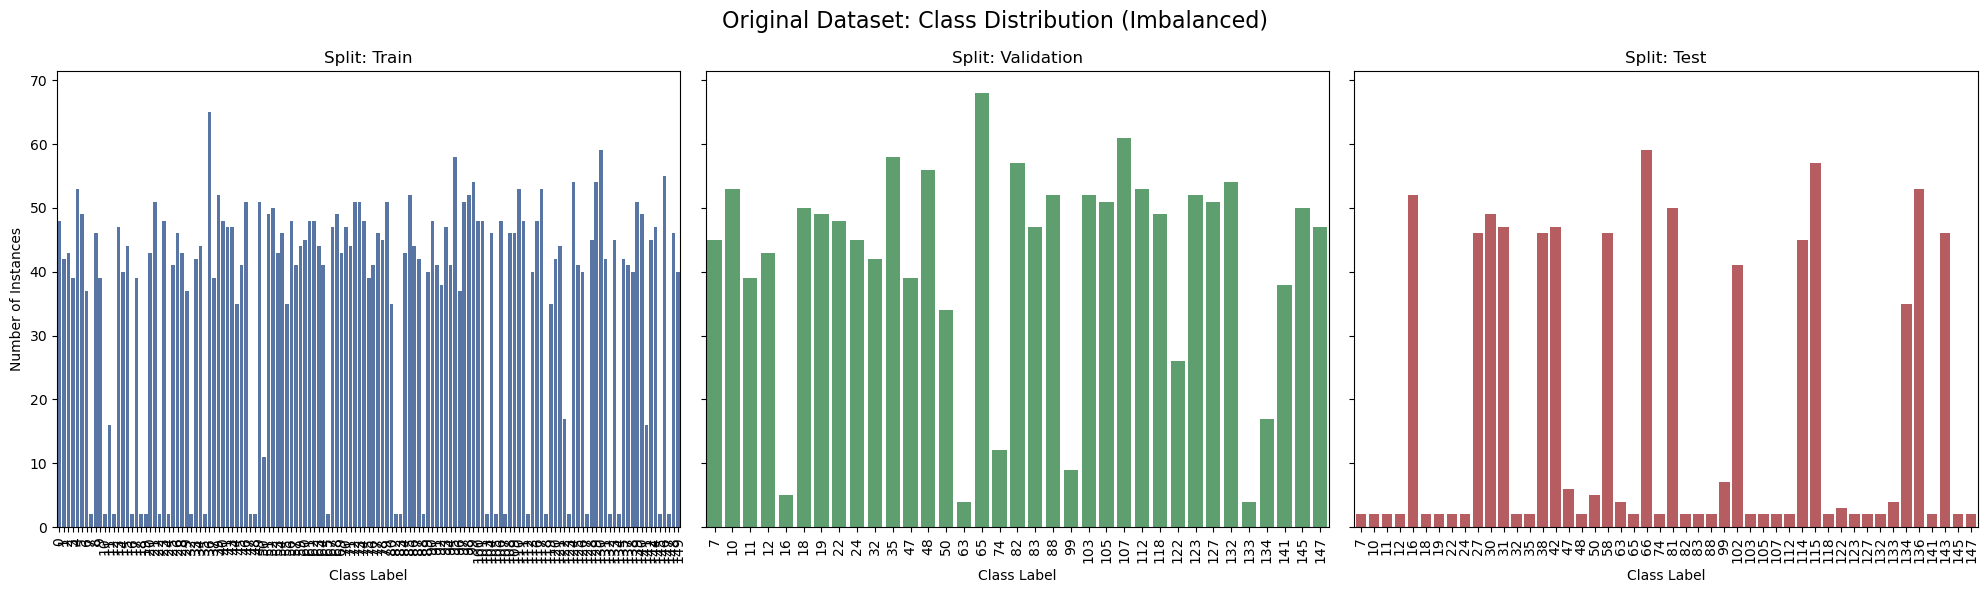

In [103]:
# Plot the number of labels of each class
plot_individual_splits(dataset, "Original Dataset: Class Distribution (Imbalanced)", swap=True)


### Dataset Already Contains Augmented Images
Upon viewing the fcakyon/pokemon-classification dataset Hugging Face, I noticed that some of the images within the dataset were already augmented. Although having augmented data is the goal, it is crucial that augmented data only is present in the **Train** set. For this reason, all augmented samples will be removed from the dataset prior to proceeding with stratified splits. Then later prior to training, I will ensure that the clean Train set contains some augmented images, such as rotations, flips, and distorations.

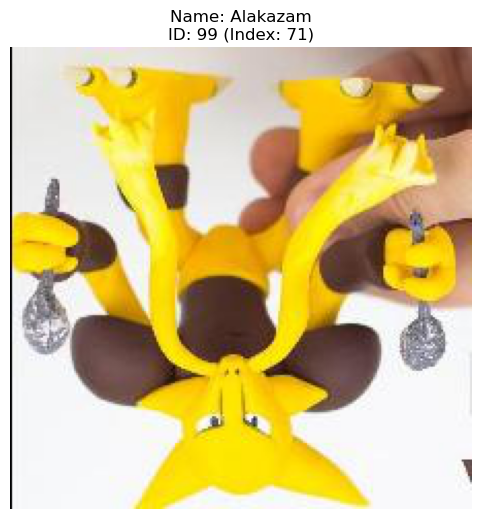

In [8]:
# Example of Augmented Image in dataset
from src.data_setup import view_dataset
augmented_sample_idx = 71
view_dataset(ds=dataset, idx=augmented_sample_idx)


### Stratify and Clean the Dataset



In [9]:
from src import sanitize_dataset

save_path = "../data/pokemon_clean"
# Merge three splits into one dataset, remove augmented images from dataset, then split into a stratifed train, val, test split
dataset_clean = sanitize_dataset(save_path=save_path, data_dir=raw_path)


Cleaned data already exists at path ../data/pokemon_clean. Skipping sanitization.


In [10]:
dataset_clean

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4672
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 584
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 585
    })
})

### Balanced Classes wrt Number of Samples per Label
The stratified splitting of the dataset successfully solved the issue of class imbalance. It would be great to have more samples for our test and validation splits, but this way we will now be able to access the performance of the model.

In [11]:
# Get number of unique labels for each split in the stratified dataset
unique_labels_cleaned = get_unique_labels(dataset_clean)

Number of unique labels for train split: 150
Number of unique labels for validation split: 150
Number of unique labels for test split: 150


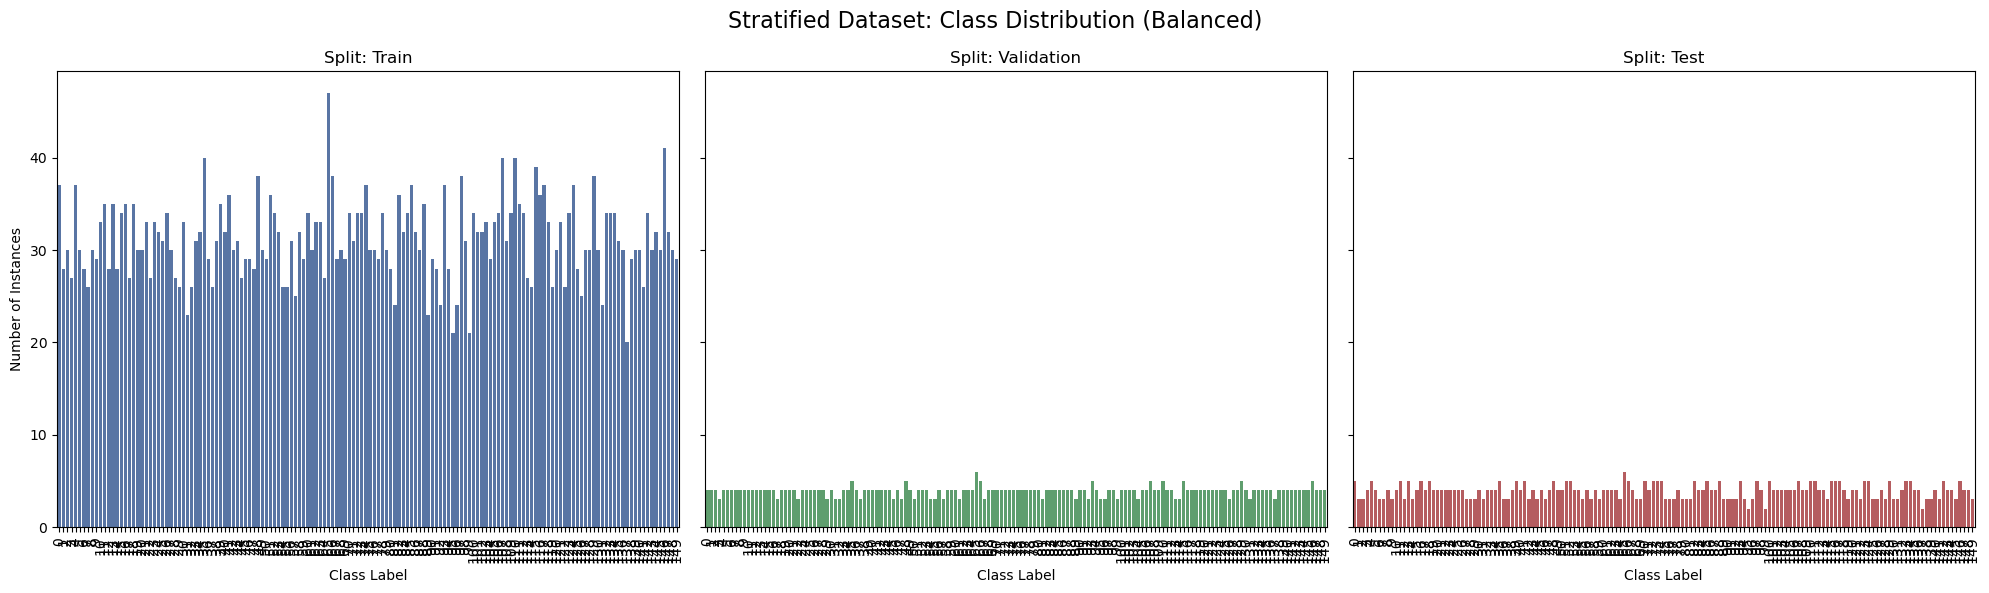

In [105]:
plot_individual_splits(dataset_clean, title="Stratified Dataset: Class Distribution (Balanced)", swap=False)

### Ensure the Same labels are Present in each Split
Although we can see that each split has 150 labels, we will now ensure that those are indeed the same 150 labels in each split.

In [13]:
def find_diff_between_labels(dataset):
    """Ensures that the labels present in each split are the same

    Args:
        dataset (DataSet): A dataset containing a train, validation, and test split.
    """
    sets_of_splits= dict()
    
    for split in dataset:
        sets_of_splits[split] = set(dataset[split]["labels"])

    train_val_diff = sets_of_splits["train"].difference(sets_of_splits["validation"])
    train_test_diff = sets_of_splits["train"].difference(sets_of_splits["test"])
    val_test_diff = sets_of_splits["validation"].difference(sets_of_splits["test"])
    
    # Check if Val/Test have labels NOT in Train 
    val_train_extra = sets_of_splits["validation"].difference(sets_of_splits["train"])
    test_train_extra = sets_of_splits["test"].difference(sets_of_splits["train"])
    
    print(f"Labels in Train match Labels in Val: {len(train_val_diff) == 0 }")
    print(f"Labels in Train match Labels in Test: {len(train_test_diff) == 0}")
    print(f"Labels in Val match Labels in Test: {len(val_test_diff) == 0 }")
    
    if not val_train_extra and not test_train_extra:
        print("Success: All labels in Val and Test are present in the Training set.")
    

In [14]:
find_diff_between_labels(dataset_clean)

Labels in Train match Labels in Val: True
Labels in Train match Labels in Test: True
Labels in Val match Labels in Test: True
Success: All labels in Val and Test are present in the Training set.


## 2. Results
### Evaluating Model Performance
I will use **Accuracy** as a primary metric to evaluate the performance of the model. As plotted above, this dataset is quite balanced with regards to the number of samples per class, meaning it is incredibly unlikely that the model will "cheat" and simply guess the same class every time. And if the model did do this, the accuracy would be extremely low, as there are 150 classes to guess from. Additionally, I will also look at **F1-Score** when looking to discover the situations in which the model did not perform well. For instance, maybe the model struggles to correctly distinguish Water type Pokémon. By solely looking at the model's overall accuracy, these valuable insights would remain hidden.

The Model's overall **Accuracy** is 67.86% and the **Top-5 Accuracy** is 89.4%. These results confirm that the model was successfully able to learn the patterns of each of the 150 Pokémon in the dataset, and when it made an incorrect prediction, it was usually a result of pokemon with similar visual features. These metrics could of course be improved by finetuning a pre-trained ResNet model, but for now I wanted to see what results I could get by starting with a messy dataset and training a model from scratch.

In [15]:
from eval import run_evaluation

labels, preds = run_evaluation()

Loading cleaned data from /Users/yassinkina/Desktop/Github/portfolio/pokemon/data/pokemon_clean
Final Counts -> Train: 4672, Val: 584, Test: 585
Starting Final Test Evaluation...
Top-1 Accuracy: 67.86%
Top-5 Accuracy: 89.40%


### An Important Realization
I initially intended to use a confusion matrix to visualize which Pokémon the model struggled with the most. However, I quickly realized that a confusion matrix with 150 classes does not provide the viewer with any useful insights. Given the large number of classes, I will primarily use figures from subsets of the data. This will be more comprehendable and make it easier to draw useful insights from them.

In [ ]:
class_names = dataset_clean["train"].features["labels"].names


### Usefulness of F1-Score
Since the dataset is quite imbalanced, with some classes having only a support of 3, F1 scores of 1 are not impressive, nor do they inform us much about the model's ability. With that said, we can still use F1 scores of the lowest performing classes, as there may be patterns amongst the labels for which the model struggled with. For instance, both Pidgeot and Pidgeotto are amongst the lowest F1 scores.  These Pokémon are both birds that belong to the same evolution family that even humans could easily confuse.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import os

def plot_top_bottom_f1(
    y_true,
    y_pred,
    class_names,
    top_k=10,
):
    # Compute per-class F1
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Remove f1 scores of 0, meaning label was not present
    f1_per_class = np.array([x for x in f1_per_class if x > 0])

    # Sort by score
    sorted_indices = np.argsort(f1_per_class)
    
    bottom_indices = sorted_indices[:top_k]
    top_indices = sorted_indices[-top_k:][::-1]

    bottom_scores = f1_per_class[bottom_indices]
    top_scores = f1_per_class[top_indices]

    bottom_names = [class_names[i] for i in bottom_indices]
    top_names = [class_names[i] for i in top_indices]

    # ===== Summary Stats =====
    print("===== F1 Summary Statistics =====")
    print(f"Macro F1: {np.mean(f1_per_class):.4f}")
    print(f"Min F1:   {np.min(f1_per_class):.4f}")
    print(f"Max F1:   {np.max(f1_per_class):.4f}")
    print(f"Std F1:   {np.std(f1_per_class):.4f}")
    print("=================================")

    # ===== Plot =====
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    axes[0].barh(bottom_names, bottom_scores)
    axes[0].set_title("Lowest Performing Classes (F1 Score)")
    axes[0].set_xlim(0, 1)
    axes[0].invert_yaxis()  # highest of bottom appears on top

    axes[1].barh(top_names, top_scores)
    axes[1].set_title("Best Performing Classes (F1 Score)")
    axes[1].set_xlim(0, 1)
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    

===== F1 Summary Statistics =====
Macro F1: 0.6885
Min F1:   0.2000
Max F1:   1.0000
Std F1:   0.1932


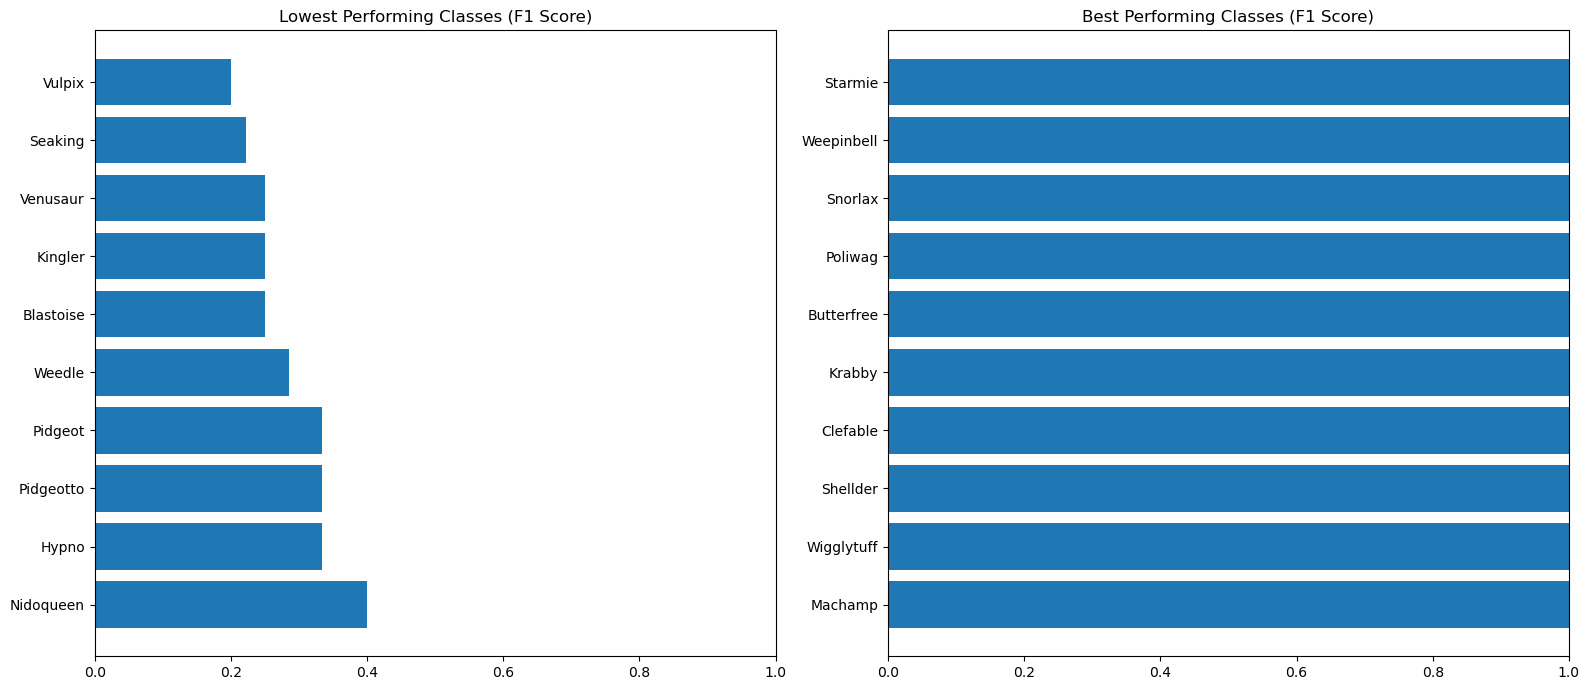

In [85]:
plot_top_bottom_f1(labels, preds, class_names)

/opt/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


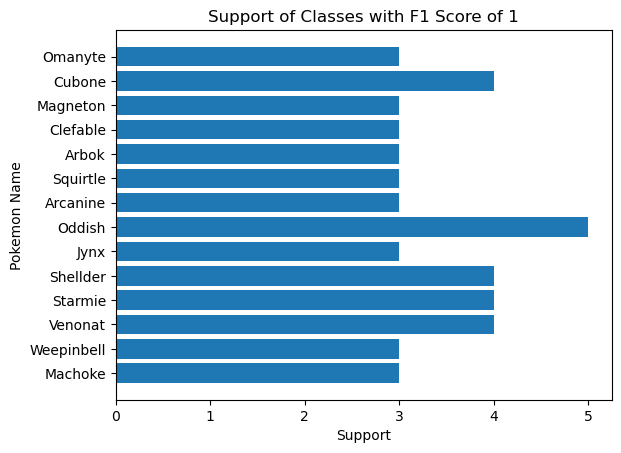

In [93]:
from sklearn.metrics import classification_report

perfect_classes = []
report = classification_report(labels, preds, target_names=class_names, output_dict=True)
# Get all labels with 1.0 f1-score
for cls, metrics, in report.items():
   
    if isinstance(metrics, dict) and "f1-score" in metrics:
        if metrics["f1-score"] == 1.0:
            perfect_classes.append(cls)
  
support = [report[cls]["support"] for cls in perfect_classes ]

plt.barh(perfect_classes, support)
plt.ylabel("Pokemon Name")
plt.xlabel("Support")
plt.title("Support of Classes with F1 Score of 1")
plt.show()




/opt/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


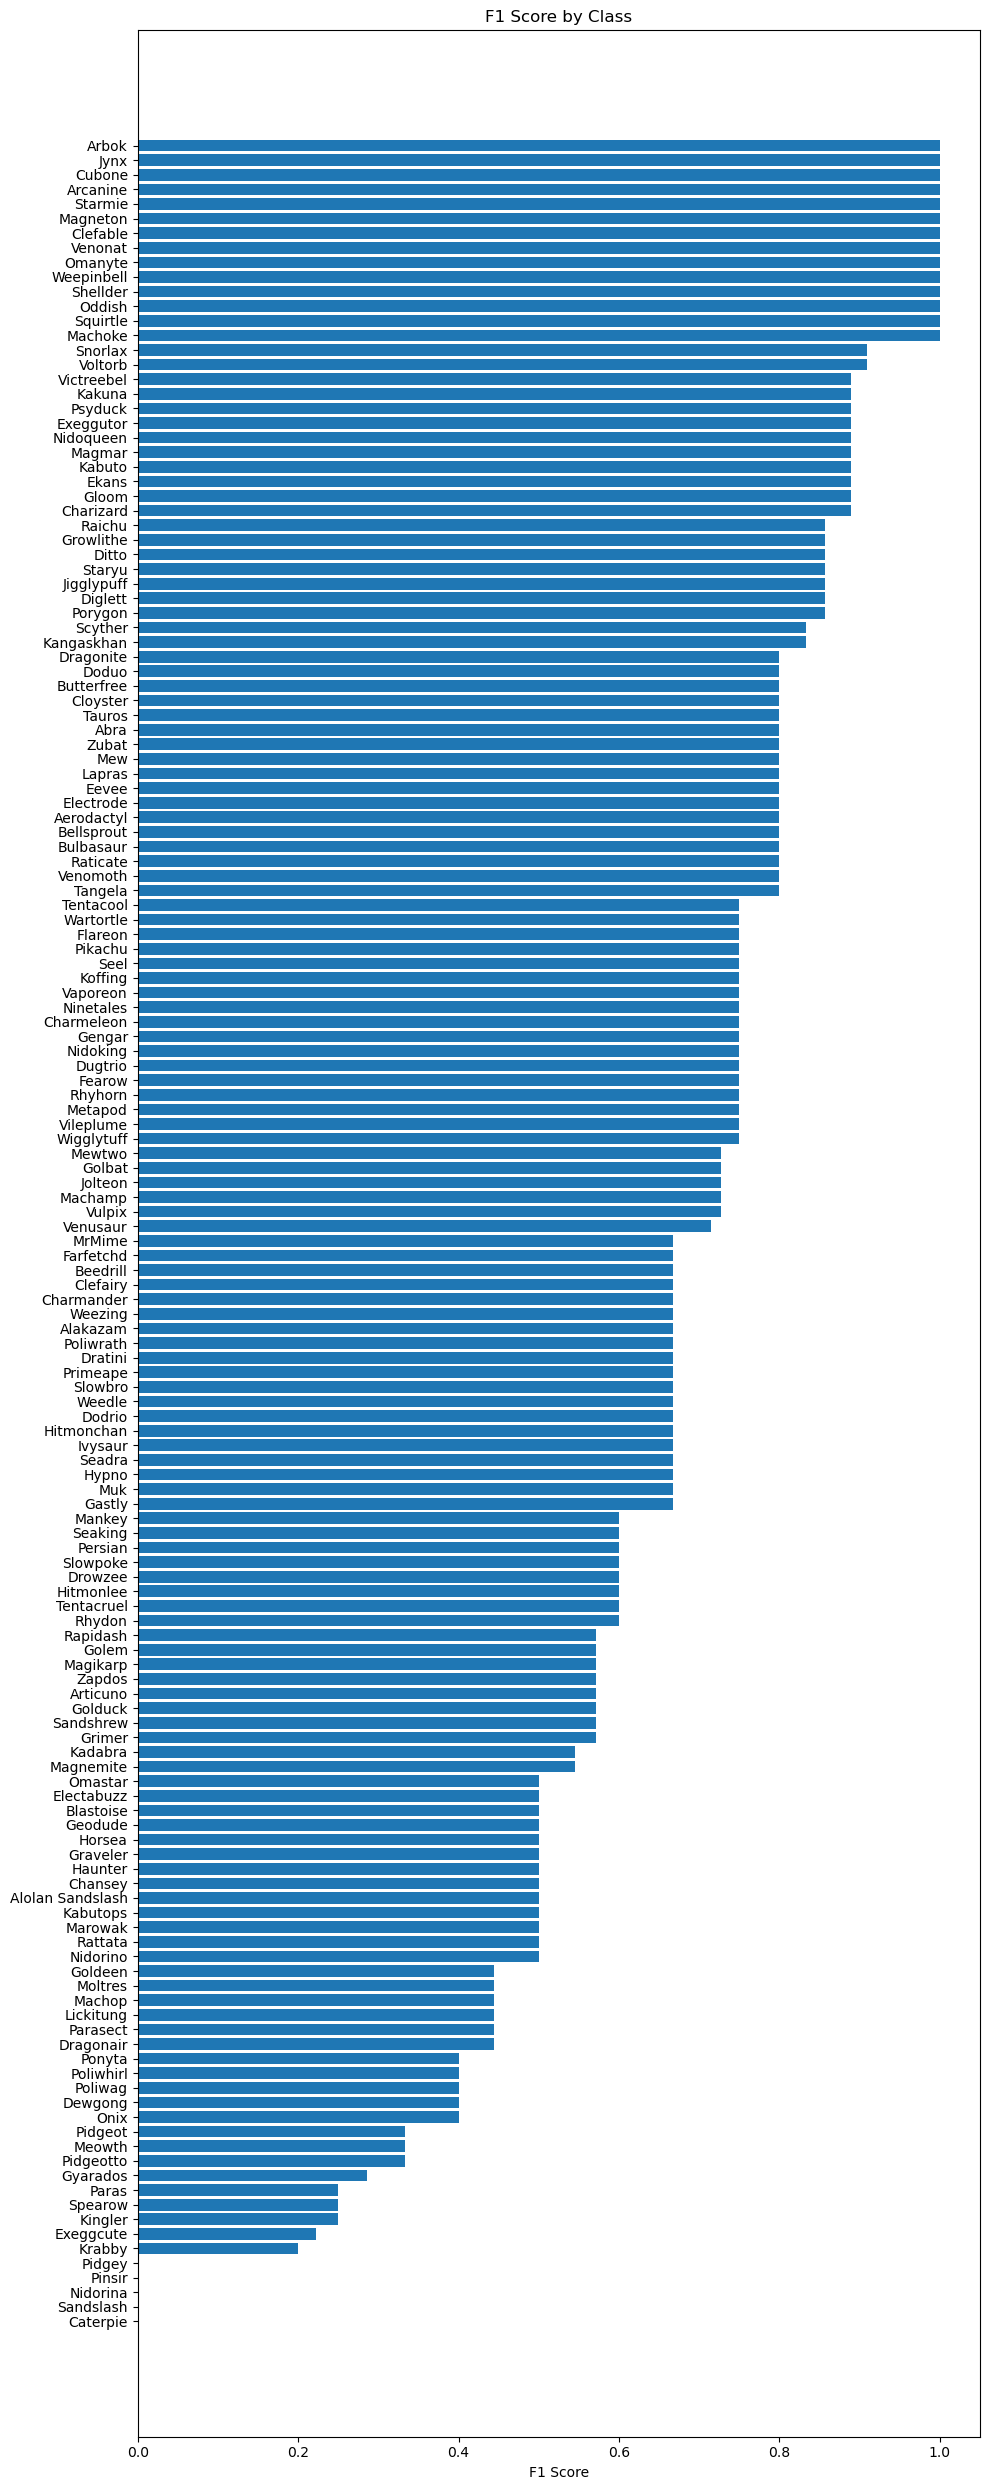

In [23]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

df = pd.DataFrame({
    "Class": class_names,
    "F1": f1
}).sort_values("F1")

# ___________TO SEE F1-SCORE CHART, UNCOMMENT CODE BELOW ____________

plt.figure(figsize=(10, 25))
plt.barh(df["Class"], df["F1"])
plt.xlabel("F1 Score")
plt.title("F1 Score by Class")
plt.tight_layout()
plt.show()


Error analysis of most confused classes in confusion matrix. 10 best classes f1 score and 10 worst

### Why does the model perform better with some classes than others?
To investigate what caused the model to have such a wide variety of F1-Scores, I first looked at the training samples for each label. I hypothesized that there would be a positive correlation between the number of training samples and the F1-Score. However, the data does not support this, as there appears to be no correlation between the number of samples and the f1 score, as shown below. 
This shows that the data augmentation and model architecture succeeded in addressing the class imbalance, meaning the issue lies not in the number of samples per class, but likely in the similarities between various Pokémon and/or the background of the images. For example, the similarities between Pokémon of the same element (e.g. Water, Fire) or the Pokémon belonging to the same evolution family (e.g. Pikachu and Raichu), or even the same Pokémon shown from different angles or lighting are all factors that could contribute to lower model performance. Similarly, some of the training data were images of Pokémon cards, which are largely similar for all Pokémon, so it is reasonable to suspect that this contributed to the lower f1 scores in certain classes.

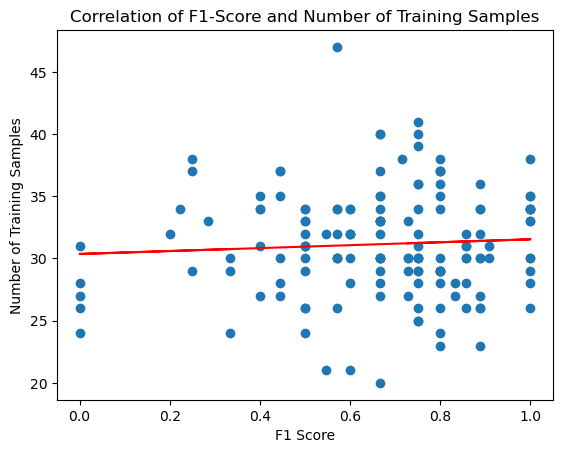

In [19]:
training_samples = list(Counter(dataset_clean["train"]["labels"]).values())
slope, intercept = np.polyfit(f1,training_samples, 1)
line = slope * f1 + intercept
# plt.scatter(x=training_samples.values(), y=f1)
plt.scatter(x=f1 , y=training_samples)
plt.plot(f1, line,color="red")
plt.title("Correlation of F1-Score and Number of Training Samples")
plt.xlabel("F1 Score" )
plt.ylabel("Number of Training Samples")
plt.plot()
plt.show()

## 3. Model Architecture

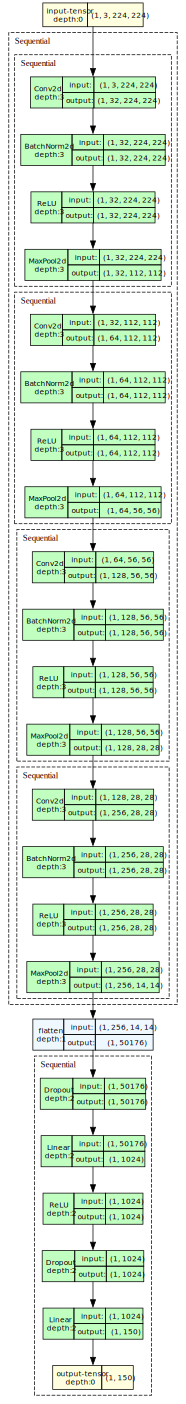

In [20]:
import sys
import os
import yaml
import torch

sys.path.append(os.path.abspath(os.path.join('..')))
from src import DynamicCNN


# Load model config
with open("../config/config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

model = DynamicCNN(
    n_layers=cfg['model']['n_layers'],
    n_filters=cfg['model']['n_filters'],
    kernel_sizes=cfg['model']['kernel_sizes'],
    dropout_rate=cfg['model']['dropout_rate'],
    fc_size=cfg['model']['fc_size'],
    num_classes=cfg['model']['num_classes']
)

model.draw_CNN(save_path="../assets/cnn_structure")

In [21]:
from torchinfo import summary
model_stats = summary(model, input_size=(1, 3, 224, 224), verbose=0)
print(model_stats)

Layer (type:depth-idx)                   Output Shape              Param #
DynamicCNN                               [1, 150]                  --
├─Sequential: 1-1                        [1, 256, 14, 14]          --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 224, 224]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 224, 224]         64
│    │    └─ReLU: 3-3                    [1, 32, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 112, 112]         --
│    └─Sequential: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 112, 112]         18,496
│    │    └─BatchNorm2d: 3-6             [1, 64, 112, 112]         128
│    │    └─ReLU: 3-7                    [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-8               [1, 64, 56, 56]           --
│    └─Sequential: 2-3                   [1, 128, 28, 28]          --
│    │   

In [22]:
# from huggingface_hub import login, upload_folder

# upload_folder(folder_path="../models/pokemon_cnn_best.pth", repo_id="yassinkina/pokemon-cnn", repo_type="model")